/home/rameyjm7/workspace/TML/lpu/llm-preference-unlearning/lpu-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] Using log file: logs/recommender_2025-11-23_16-03-59.json
[INFO] Encoding responses...
[INFO] Drift metrics saved to logs/drift_summary.csv


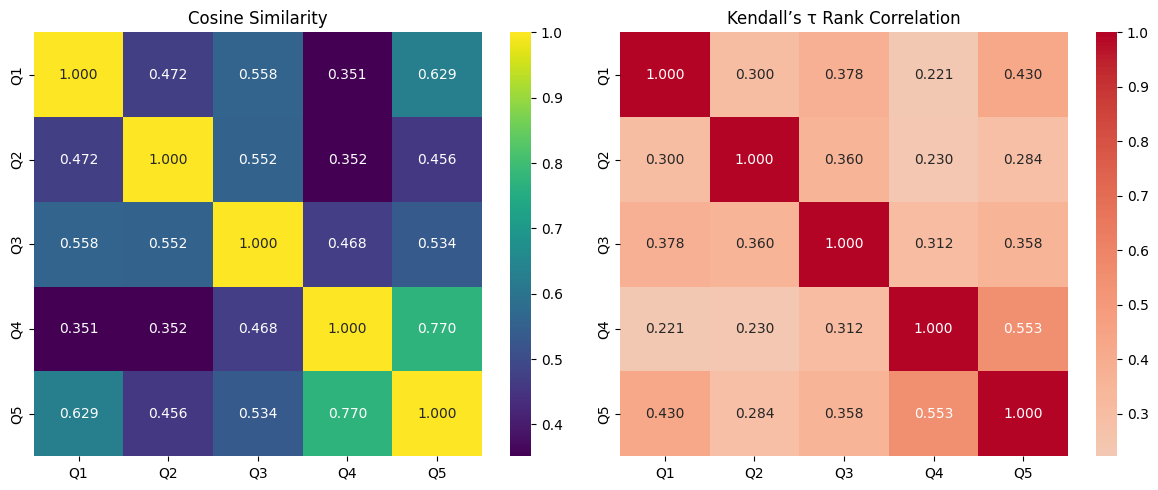

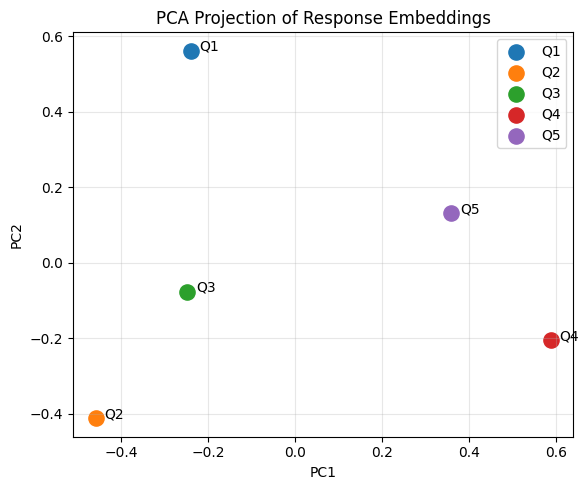

[RESULT] Mean pairwise cosine similarity: 0.5142
[RESULT] Mean pairwise Kendall’s τ: 0.3426


In [1]:
#!/usr/bin/env python3
"""
Phase 2.3 — Drift Metric Visualization + Quantitative Drift Table
Computes cosine similarity and Kendall’s τ between prompt responses,
visualizes both, and saves drift_summary.csv.
"""
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from itertools import combinations
from scipy.spatial.distance import cosine
from scipy.stats import kendalltau
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

# ---------------------------------------------------------------------
# Load latest recommender JSON log
# ---------------------------------------------------------------------
log_dir = "logs"
log_files = sorted([
    f for f in os.listdir(log_dir)
    if f.startswith("recommender_") and f.endswith(".json")
])
if not log_files:
    raise FileNotFoundError("No recommender_*.json logs found in ./logs/")
latest_log = os.path.join(log_dir, log_files[-1])
print(f"[INFO] Using log file: {latest_log}")

with open(latest_log, "r", encoding="utf-8") as f:
    data = json.load(f)
records = data["records"]
questions = [r["question"] for r in records]
responses = [r["answer"] for r in records]
ids = [r["id"] for r in records]

# ---------------------------------------------------------------------
# Encode responses → sentence embeddings
# ---------------------------------------------------------------------
print("[INFO] Encoding responses...")
embedder = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedder.encode(responses, convert_to_numpy=True, normalize_embeddings=True)
n = len(responses)

# ---------------------------------------------------------------------
# Compute pairwise cosine & Kendall’s τ
# ---------------------------------------------------------------------
cosine_matrix = np.zeros((n, n))
tau_matrix = np.zeros((n, n))
pairs, cosine_vals, tau_vals = [], [], []

for i, j in combinations(range(n), 2):
    cos_sim = 1 - cosine(embeddings[i], embeddings[j])
    cosine_matrix[i, j] = cosine_matrix[j, i] = cos_sim
    # Kendall’s τ on raw embedding vectors (flattened order)
    tau, _ = kendalltau(embeddings[i], embeddings[j])
    tau_matrix[i, j] = tau_matrix[j, i] = tau
    pairs.append((i + 1, j + 1))
    cosine_vals.append(cos_sim)
    tau_vals.append(tau)
np.fill_diagonal(cosine_matrix, 1.0)
np.fill_diagonal(tau_matrix, 1.0)

# ---------------------------------------------------------------------
# Save drift summary CSV
# ---------------------------------------------------------------------
summary_path = os.path.join(log_dir, "drift_summary.csv")
df_summary = pd.DataFrame({
    "Prompt_i": [p[0] for p in pairs],
    "Prompt_j": [p[1] for p in pairs],
    "Cosine_Similarity": cosine_vals,
    "Kendall_Tau": tau_vals
})
df_summary.to_csv(summary_path, index=False)
print(f"[INFO] Drift metrics saved to {summary_path}")

# ---------------------------------------------------------------------
# Visualize cosine & τ matrices
# ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cosine_matrix, ax=axes[0], annot=True, fmt=".3f",
            xticklabels=[f"Q{i}" for i in ids], yticklabels=[f"Q{i}" for i in ids],
            cmap="viridis")
axes[0].set_title("Cosine Similarity")

sns.heatmap(tau_matrix, ax=axes[1], annot=True, fmt=".3f",
            xticklabels=[f"Q{i}" for i in ids], yticklabels=[f"Q{i}" for i in ids],
            cmap="coolwarm", center=0)
axes[1].set_title("Kendall’s τ Rank Correlation")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# PCA projection (same as before)
# ---------------------------------------------------------------------
pca = PCA(n_components=2)
emb2d = pca.fit_transform(embeddings)
plt.figure(figsize=(6, 5))
for i, (x, y) in enumerate(emb2d):
    plt.scatter(x, y, s=120, label=f"Q{i+1}")
    plt.text(x + 0.02, y, f"Q{i+1}", fontsize=10)
plt.title("PCA Projection of Response Embeddings")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# ---------------------------------------------------------------------
# Mean similarity report
# ---------------------------------------------------------------------
mean_cos = np.mean(cosine_matrix[np.triu_indices(n, 1)])
mean_tau = np.mean(tau_matrix[np.triu_indices(n, 1)])
print(f"[RESULT] Mean pairwise cosine similarity: {mean_cos:.4f}")
print(f"[RESULT] Mean pairwise Kendall’s τ: {mean_tau:.4f}")
